<a href="https://colab.research.google.com/github/jdclifton2/researchCode/blob/master/Function_Timing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testing Function Runtime for Bipartite Graphs Improved 

> "Timing two functions to see which is faster."

- toc:false
- branch: master
- badges: true
- comments: true
- author: JC
- categories: [networkx, graphs, unit testing, timeit, python]

In [ ]:
import networkx as nx
from typing import Dict, Tuple, List
import numpy as np
from numpy.random import geometric
import timeit
from random import randrange, randint
import pandas as pd

The goal of this notebook is to compare the speed of functions designed to find all neighbors within distance 3 of a given vertex. The current function on the gitcoin repository utilizes a generate and filter methodology. We propose that the ego_graph() function in networkx is superior for large bipartite graphs. We will now offer justification for this proposal by using simulations and the timeit library.

#### The current function in the github repo.

In [ ]:
def robust_shortest_path_length(*args, **kwargs) -> float:
    output = np.inf
    try:
        output = nx.shortest_path_length(*args, **kwargs)
    finally:
        return output

def NeighborsSubgraph(contribution_graph: nx.Graph, grant: str) -> nx.Graph:
    """"""
    source = grant
    distances_to_source = {
        target: robust_shortest_path_length(contribution_graph, source, target)
        for target in contribution_graph.nodes
    }

    neighbors = [
        node for (node, distance) in distances_to_source.items() if distance <= 3
    ]

    neighbors_subgraph = contribution_graph.subgraph(neighbors)
    return neighbors_subgraph

#### Proposed function

In [ ]:
def Neighbors(contribution_graph: nx.Graph, grant: str) -> nx.Graph:
    """"""
    return nx.ego_graph(contribution_graph, grant, radius=3, center=False)


The relationship between donators and projects can be modeled as a bipartite graph. Therefore, bipartite graphs will be the structure that this function acts upon and will need to be the most optimized case. A bipartite graph, also called a bigraph, is a set of graph vertices decomposed into two disjoint sets such that no two graph vertices within the same set are adjacent. We will now write a class that will act as a simulation case. The constructor create a random bipartite graph using this definition.

In [ ]:
class FundingSimulation:

  def __init__(self, num_funders, num_grants):
    """
    This class represents a simulation of a quadratic funding situation. 
    
    :param num_funders: The number of desired funders.
    :param num_grants: The number of desired grants.
    :return: A bipartite graph with random edges.
    """

    #create two disjoin sets
    self.funders = set(range(0, num_funders))
    self.grants = set(range(num_funders, num_funders + num_grants))
    
    bipart = nx.Graph()
    
    bipart.add_nodes_from(self.funders, bipartite=0)
    bipart.add_nodes_from(self.grants, bipartite=1)
    
    
    for vert_a in self.funders:
        
        #the number of edges a specific vertex will have
        num_edges = geometric(p=0.35)
        
        for edge in range(num_edges):
            #pick a random vertex from set_b
            vert_b = randrange(num_funders, num_funders + num_grants)
            bipart.add_edge(vert_a, vert_b)
        
    self.bipart = bipart

In [ ]:
def create_simulations(num_sims = 50, max_funders = 20, min_funders = 1, max_grants = 20, min_grants = 1, min_enteries = 1):
    """
    This function creates a suite of random quadratic funding simulations.
    :param num_sims: The number of simulations to generate.
    :param max_funders: The maximum number of funders any sim in the suite can have.
    :param min_funders: The minimum number of funders any sim in the suite can have.
    :param max_grants: The maximum number of grants any sim in the suite can have.
    :param min_grants: The minimum number of grants any sim in the suite can have.
    :param min_enteries: The minimum number of simulations performed.
    
    :return: An array of random graphs. 
    """
    simulations = []
    for i in range(min_enteries, num_sims + 1):

        num_funders = randint(min_funders, max_funders)

        num_grants = randint(min_grants, max_grants)

        simulation = FundingSimulation(num_funders, num_grants)
        simulations.append(simulation)
    
    return np.array(simulations, dtype=object)
    
    

In [ ]:
simulations = create_simulations(num_sims = 500, max_funders = 30)

In [ ]:
def create_times_df(simulations):
    
    #df = pd.DataFrame(columns=["original_func_time", "new_func_time" , "num_edges", "num_verticies"])
    df = pd.DataFrame(columns=["original_func_time", "new_func_time" , "num_funders", "num_grants", "num_edges", "num_verticies", 
                               'start_vert'])
    for simulation in simulations:

        start_vert = randrange(0, len(simulation.grants))

        
        #closure is needed for the timeit library to work
        def func1():
            
            def closure():
                return NeighborsSubgraph(simulation.bipart, start_vert)
    
            t1 = timeit.timeit(closure, number=100)
            return t1
        
        def func2():
            
            def closure2():
                return Neighbors(simulation.bipart, start_vert)
    
            t2 = timeit.timeit(closure2, number=100)
        
            return t2

        num_verticies = len(simulation.bipart)
        num_edges = simulation.bipart.number_of_edges()
        #set_a,set_b = bipartite.sets(graph)
        num_funders = len(simulation.funders)
        num_grants = len(simulation.grants)
        series = {
            "original_func_time": func1(),
            "new_func_time":  func2(),
            "num_funders": num_funders,
            "num_grants": num_grants,
            "num_edges": num_edges,
            "num_verticies": num_verticies,
            "start_vert": start_vert,
        }
        df = df.append(series, ignore_index=True)
    return df





In [ ]:
df = create_times_df(simulations)

In [ ]:
df.head()

,original_func_time,new_func_time,num_funders,num_grants,num_edges,num_verticies,start_vert
0,0.036941,0.039523,8.0,15.0,20.0,23.0,14.0
1,0.029532,0.050718,14.0,6.0,30.0,20.0,0.0
2,0.045379,0.065157,26.0,2.0,37.0,28.0,1.0
3,0.091849,0.062562,28.0,20.0,72.0,48.0,14.0
4,0.012466,0.026666,10.0,1.0,10.0,11.0,0.0


# Plotting the results

## Test Suite 1

In [ ]:
from matplotlib import pyplot

def create_plots(df):
  """
  Creates a set of plots for run times of two functions when those functions
  are applied to specific simulations.

  :param df: The dataframe to create plots for.
  """


  pyplot.figure(figsize=(20,20))

  pyplot.subplot(3, 2, 1)
  pyplot.hist(df['original_func_time'], bins = 40, label='original function')
  pyplot.hist(df['new_func_time'], bins = 40, label='new function')
  pyplot.legend(loc='upper right')
  pyplot.title('Function Runtime Comparison')
  pyplot.xlabel('Function Runtime')
  pyplot.ylabel('frequency')

  
  pyplot.subplot(3, 2, 2)
  pyplot.hist(df['new_func_time'], bins = 40, label='new function', color = 'orange')
  pyplot.hist(df['original_func_time'], bins = 40, label='original function', color = 'blue')
  pyplot.legend(loc='upper right')
  pyplot.title('Function Runtime Comparison')
  pyplot.xlabel('Function Runtime')
  pyplot.ylabel('frequency')


  pyplot.subplot(3, 2, 3)
  x = df['num_edges']
  y = df['new_func_time']
  pyplot.scatter(x,y)
  pyplot.title("New Runtime vs Graph Size")
  pyplot.xlabel("Size")
  pyplot.ylabel("New Runtime")



  pyplot.subplot(3, 2, 4)

  x = df['num_edges']
  y = df['original_func_time']
  pyplot.scatter(x,y)
  pyplot.title("Original Runtime vs Graph Size")
  pyplot.xlabel("Size")
  pyplot.ylabel("Original Runtime")


  pyplot.subplot(3, 2, 5)

  x = df['num_funders']
  y = df['original_func_time']
  pyplot.scatter(x,y)
  pyplot.title("Original Runtime vs Number of Funders")
  pyplot.xlabel("num funders")
  pyplot.ylabel("Original Runtime")

  pyplot.subplot(3, 2, 6)

  x = df['num_grants']
  y = df['original_func_time']
  pyplot.scatter(x,y)
  pyplot.title("Original Runtime vs Number of Grants")
  pyplot.xlabel("num grants")
  pyplot.ylabel("Original Runtime")


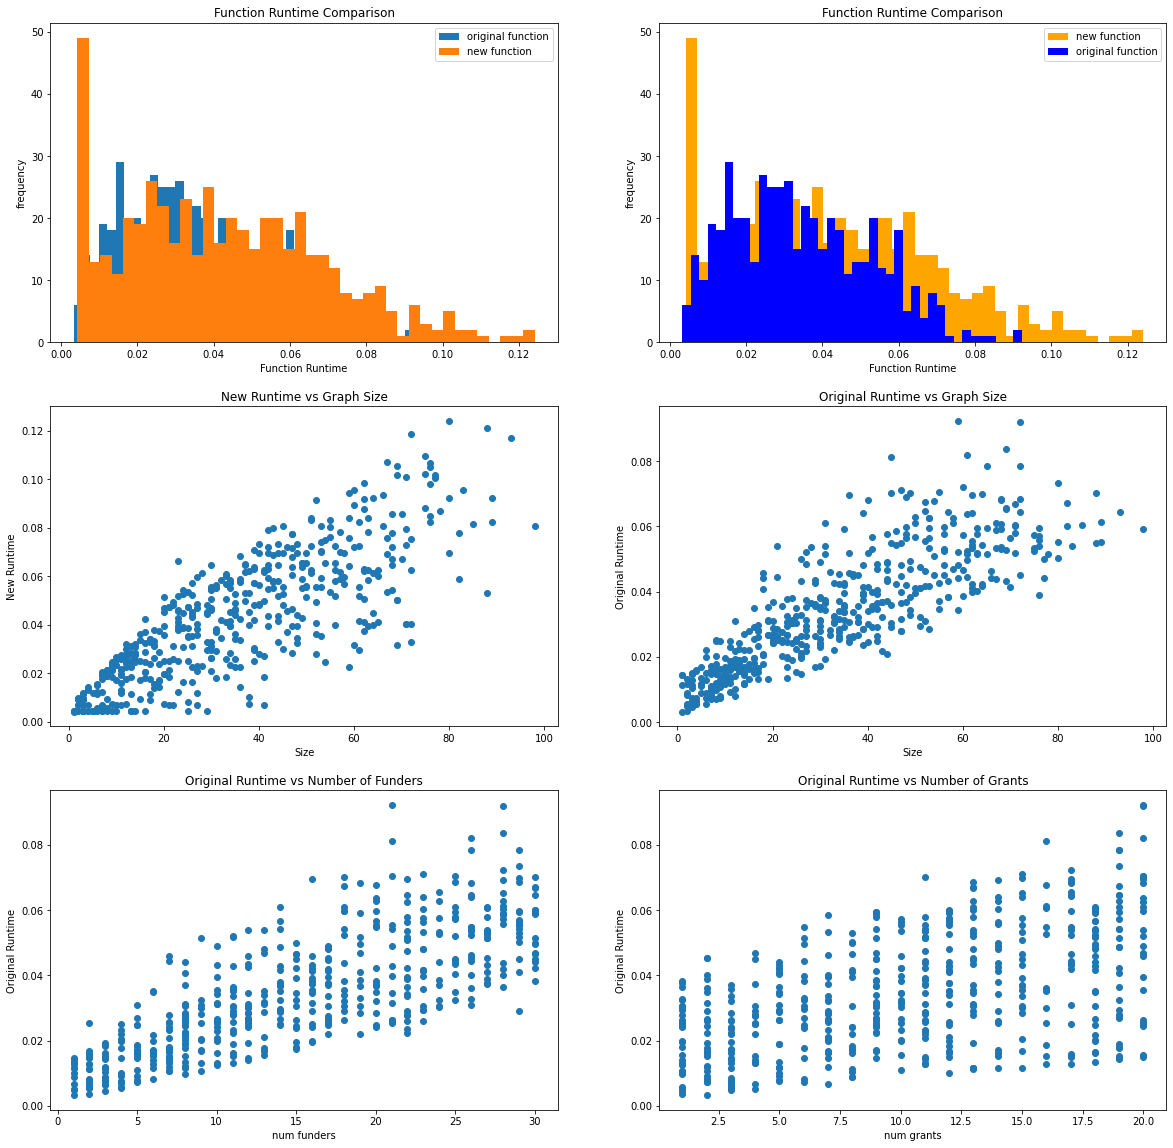

In [ ]:
create_plots(df)

In [ ]:
df.head()

,original_func_time,new_func_time,num_funders,num_grants,num_edges,num_verticies,start_vert
0,0.036941,0.039523,8.0,15.0,20.0,23.0,14.0
1,0.029532,0.050718,14.0,6.0,30.0,20.0,0.0
2,0.045379,0.065157,26.0,2.0,37.0,28.0,1.0
3,0.091849,0.062562,28.0,20.0,72.0,48.0,14.0
4,0.012466,0.026666,10.0,1.0,10.0,11.0,0.0


## Test Suite 2

In [ ]:
simulations = create_simulations(num_sims = 500, max_funders= 400, min_funders=20)
df2 = create_times_df(simulations)

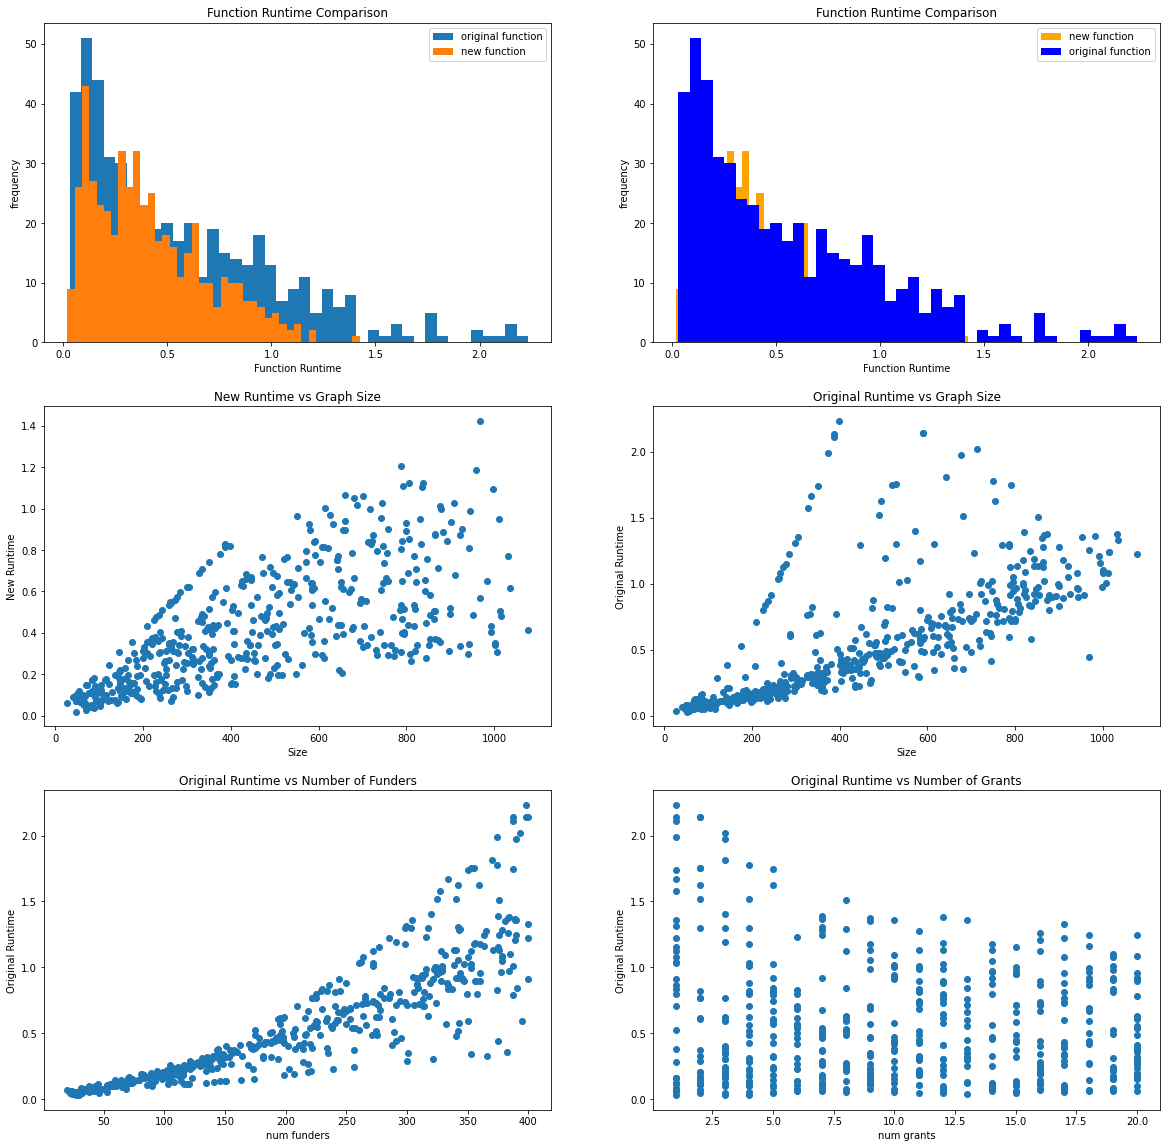

In [ ]:
create_plots(df2)

## Test Suite 3

In [ ]:
simulations = create_simulations(num_sims = 500, max_funders= 300, min_funders=20, max_grants=100, min_grants=20)
df3 = create_times_df(simulations)

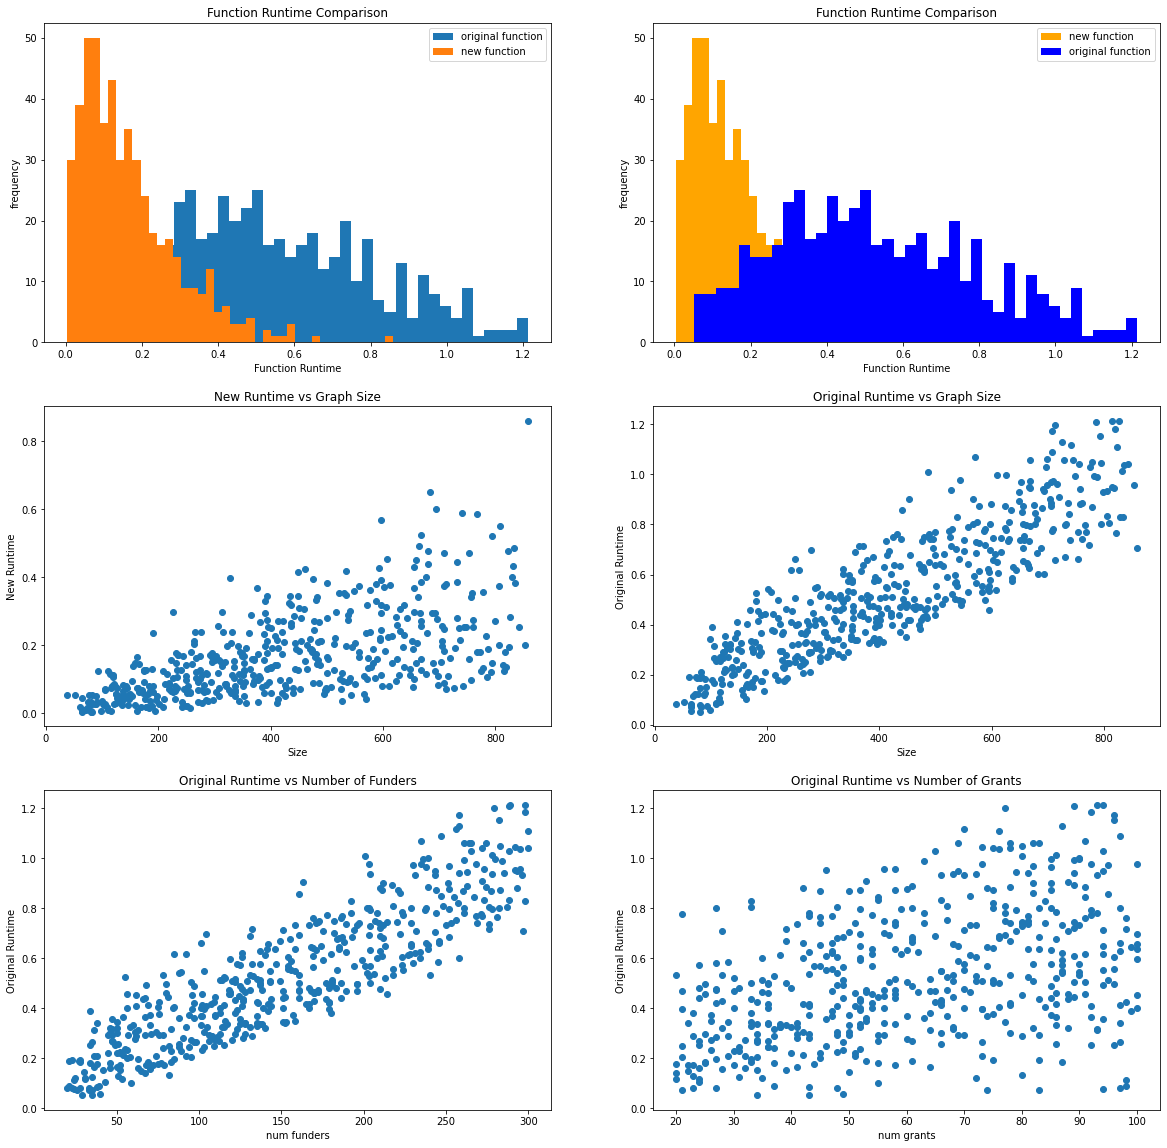

In [ ]:
create_plots(df3)

## Test Suite 4

In [ ]:
simulations = create_simulations(num_sims = 500, max_funders= 1000, min_funders=400, max_grants=100, min_grants=20)
df4 = create_times_df(simulations)

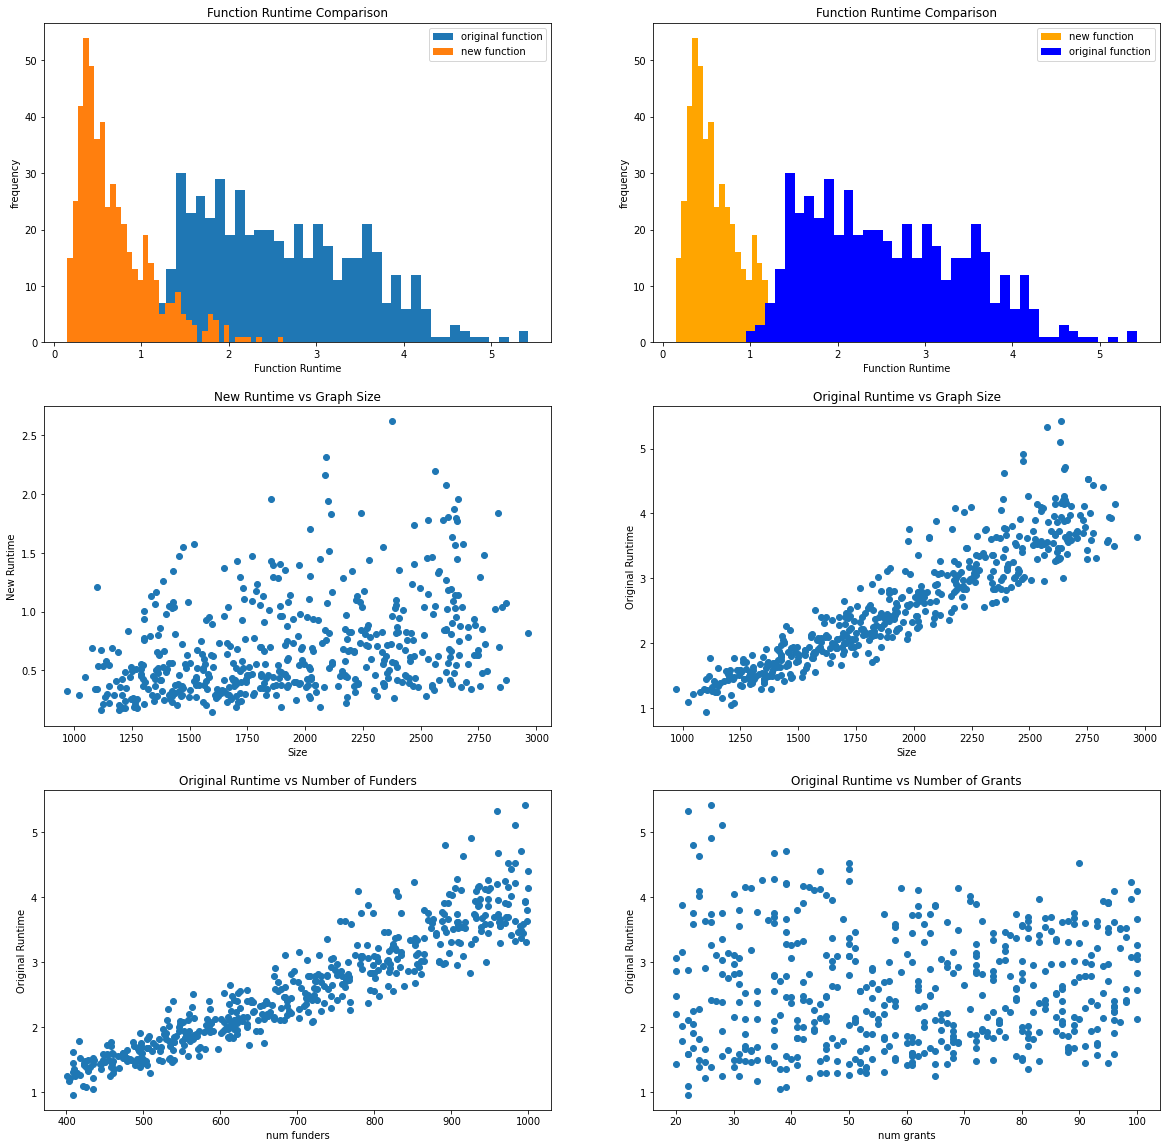

In [ ]:
create_plots(df4)

## Test Suite 5

In [ ]:
simulations = create_simulations(num_sims = 500, max_funders= 2000, min_funders=400, max_grants=400, min_grants=100)
df5 = create_times_df(simulations)

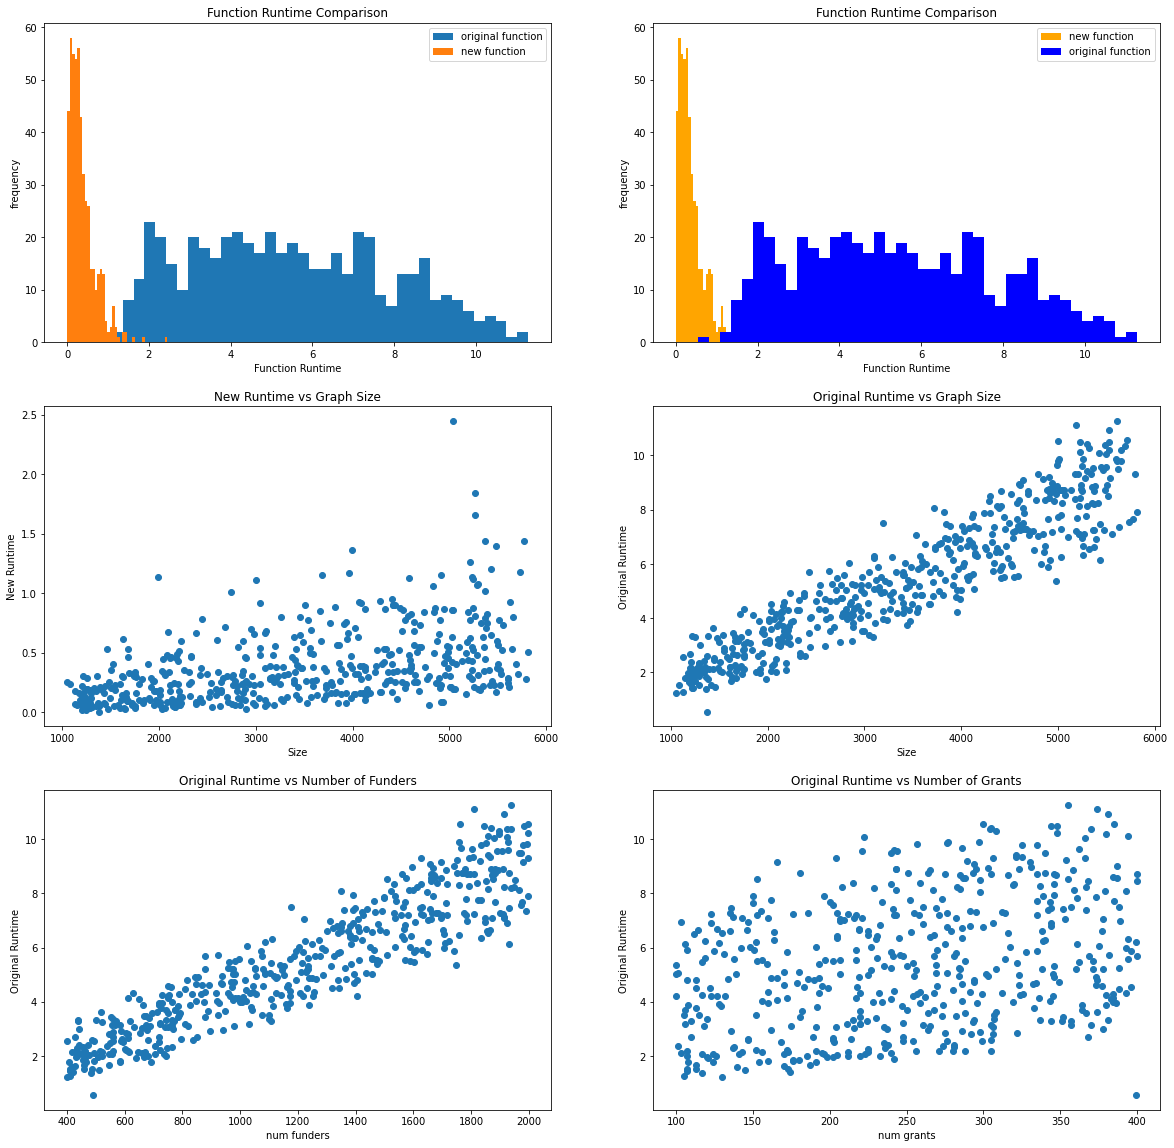

In [ ]:
create_plots(df5)

## Test Suite 6

In [ ]:
simulations = create_simulations(num_sims = 500, max_funders= 100, min_funders=30, max_grants=300, min_grants=200)
df6 = create_times_df(simulations)

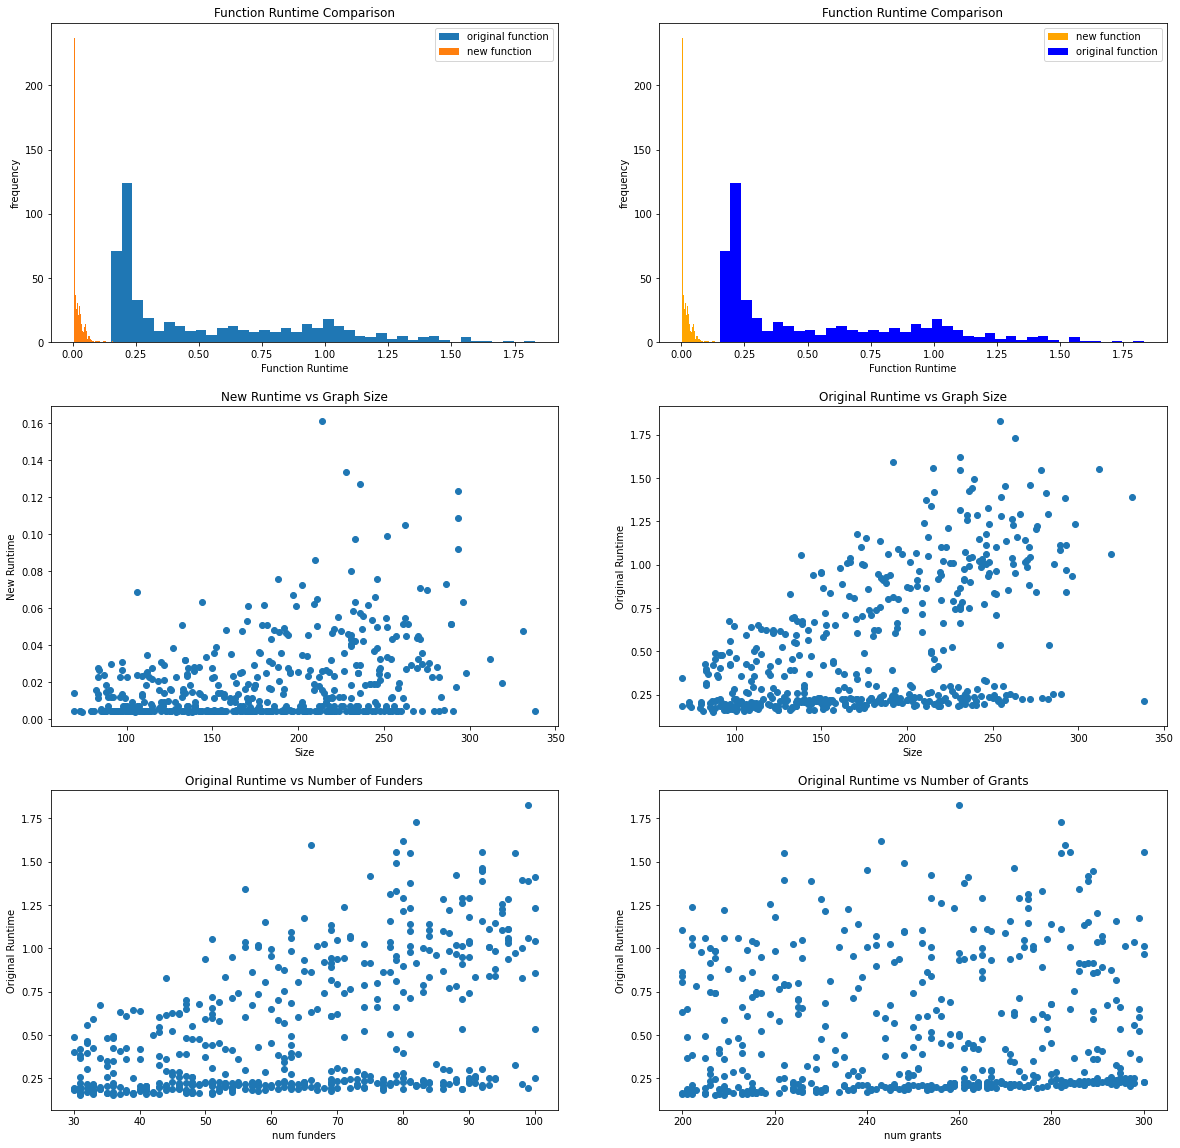

In [ ]:
create_plots(df6)

# Test Suite 7

In [ ]:
simulations = create_simulations(num_sims = 500, max_funders= 3000, min_funders=2000, max_grants=500, min_grants=300)
df7 = create_times_df(simulations)

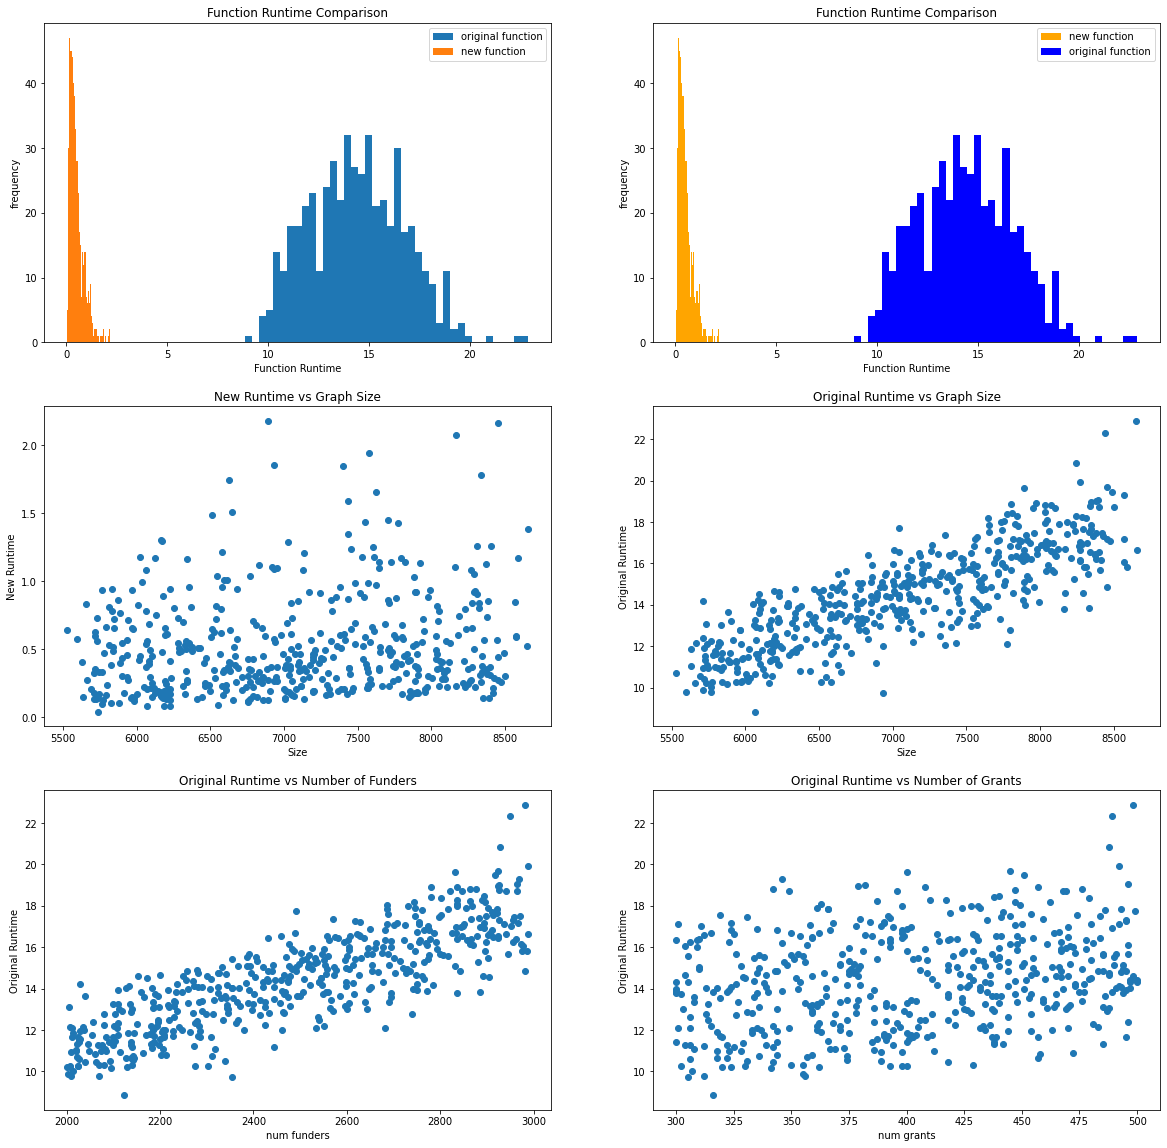

In [ ]:
create_plots(df7)

In [ ]:
create_plots(df8)

In [ ]:
import unittest as ut
from networkx.algorithms import bipartite
class TestBipartite(ut.TestCase):
  
    def test_rand_bipartite_creator(self):
        results = []
        for i in range(1,1000):
            set_a_card = randint(1, 1000)
            offset = randint(2,1000)
            set_b_card = randint(set_a_card + 1, set_a_card + offset)
            graph = random_bipartite(set_a_card, set_b_card)
            result = bipartite.is_bipartite(graph)
            results.append(result)
        condition = False in results
        self.assertFalse(condition)
    
    
    def test_create_simulations(self):
        graphs = create_simulations()
        
        self.assertEqual(len(graphs), 50)
        results = [bipartite.is_bipartite(graph.bipart) for graph in graphs]
        condition = False in results
        self.assertFalse(condition)
        

ut.main(argv=[''], exit=False)